Por: Fernando Gómez Perera

El objetivo de esta práctica es explorar implementaciones de las funciones K y L para analizar patrones puntuales.

In [1]:
pacman::p_load(GISTools, spatstat, sf, maptools, install = FALSE, update = FALSE)

El conjunto de datos a usar contiene la geolocalización de eventos denominados *breach of peace* o *alteración del orden* en la ciudad de New Haven, Connecticut, en EUA.

In [2]:
data(newhaven)
head(breach)

SpatialPoints:
         Long      Lat
[1,] 551419.5 181266.3
[2,] 556319.5 177580.7
[3,] 551423.1 172304.5
[4,] 550261.9 182613.2
[5,] 555168.5 172163.4
[6,] 549133.6 169623.6
Coordinate Reference System (CRS) arguments: +proj=lcc +datum=NAD27
+lon_0=-72d45 +lat_1=41d52 +lat_2=41d12 +lat_0=40d50
+x_0=182880.3657607315 +y_0=0 +units=us-ft +no_defs +ellps=clrk66
+nadgrids=@conus,@alaska,@ntv2_0.gsb,@ntv1_can.dat 

Este conjunto de datos usa como Sistema de Coordenadas de Referencia (CRS) el datum *NAD27* (North American Datum of 1927), y su unidad de medida se encuentra en pies de EUA.

Los eventos se visualizan en la siguiente gráfica, junto con el mapa de New Haven para entender su comportamiento.

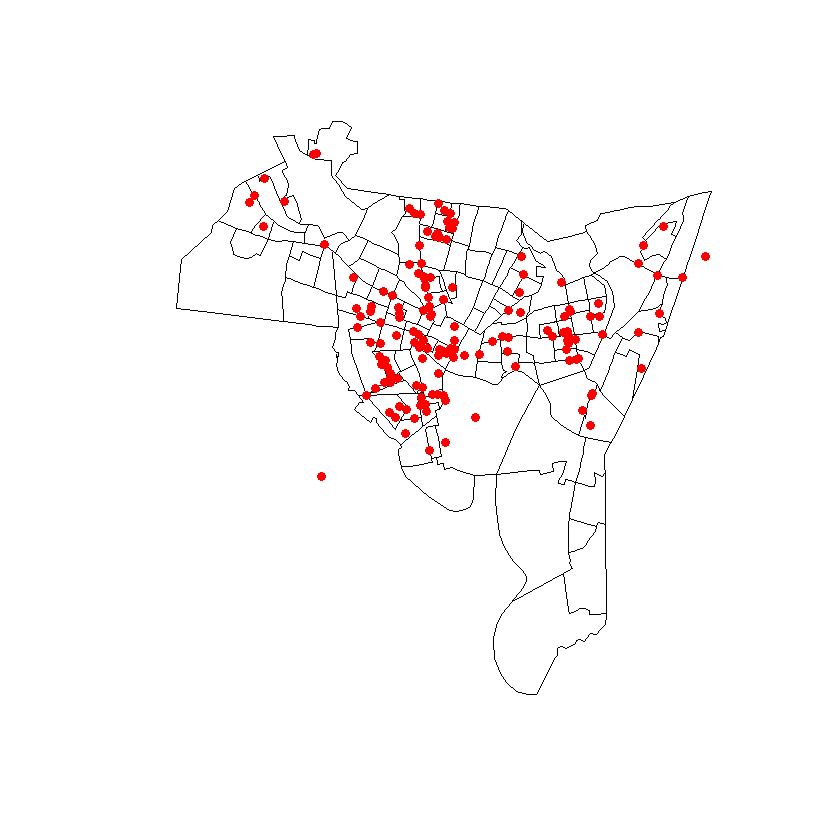

In [3]:
plot(blocks)
plot(breach, pch = 16, col = "red", add = TRUE)

Graficando solamente las coordenadas, se visualiza la dispersión que tienen los datos. Como los datos se encuentran en pies de EUA, las coordenadas tienen valores muy grandes.

Visualizar los datos de esta forma es de suma importancia, pues así será posible definir de mejor forma los valores de las variables que se usarán para calcular las funciones.

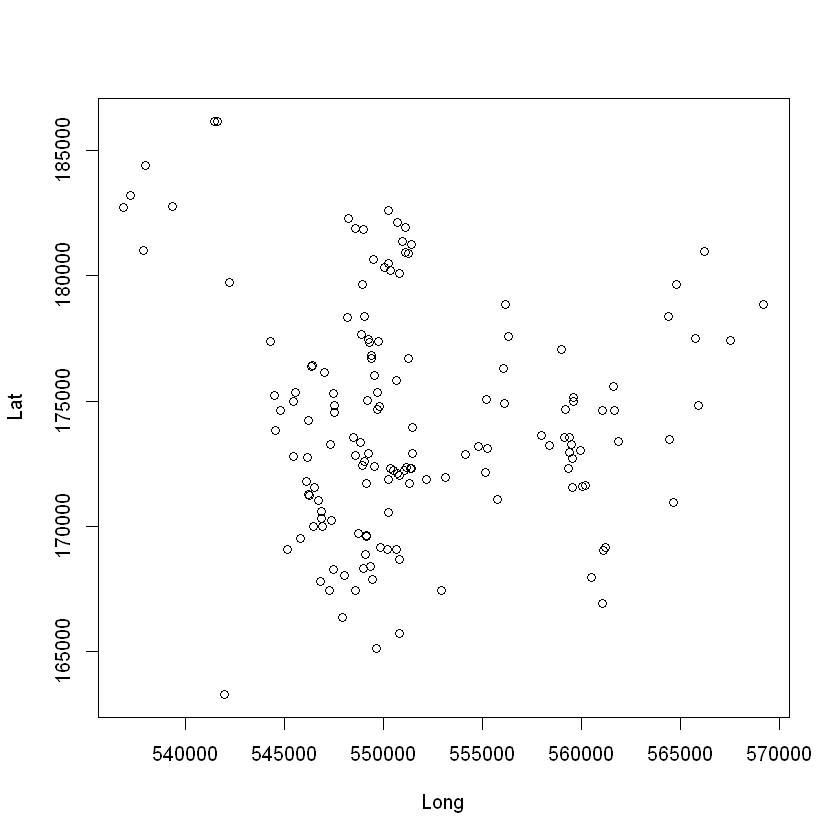

In [4]:
plot(breach@coords)

# Evaluación de la función K

Con esta función se busca identificar si un conjunto de puntos forman un grupo denso o si estos se encuentran uniformemente dispersos. Si se encuentran uniformemente dispersos, entonces no sería posible identificar una región que fuera más afectada por los eventos.

La función K proviene de las siguientes ecuaciones:

> * La **intensidad** de eventos se define como:
> $$\lambda = \frac{N}{A}$$
> donde $N$ es el total de puntos y $A$ el área del rectángulo sobre el que están distribuidos.

> * El valor esperado de eventos en una región circular de radio $r$ se define como:
> $$E(r) = \lambda \times \pi  r^2$$
> siempre y cuando el circulo se encuentre dentro del rectángulo.

Finalmente, la función K, para una distribución cualquiera de eventos, se define como:

$$K(r) = \frac{E(r)}{\lambda}$$

La cual es evaluada tomando la distancia Euclideana entre cada par de puntos dentro del radio de la región circular de la siguiente forma:

$$K(r) = \frac{E(r)}{\lambda} \approx \lambda^{-1}\frac{\sum_i\sum_{j\neq i} I(d_{ij} < r)}{n}$$

donde $d_{ij}$ es la distancia entre los puntos $x_i$ y $x_j$, la cual se evalúa usando la *función indicador*:

$$I(d_{ij} < r) 
\begin{cases}
    1, & \text{ Si } d_{ij} < r \\
    0, & \text{ en caso contrario}\\
\end{cases}
$$

y $n = N$.

De la gráfica de dispersión, se concluye que un valor adecuado de $r$ podría ser de 500 pies, y que el valor de $A$ se puede calcular usando los límites del rectángulo que se forma tomando los puntos extremos del conjunto de datos (también conocido como *bbox*).

## Implementación manual

La implementación manual de la función K arroja la siguiente gráfica:

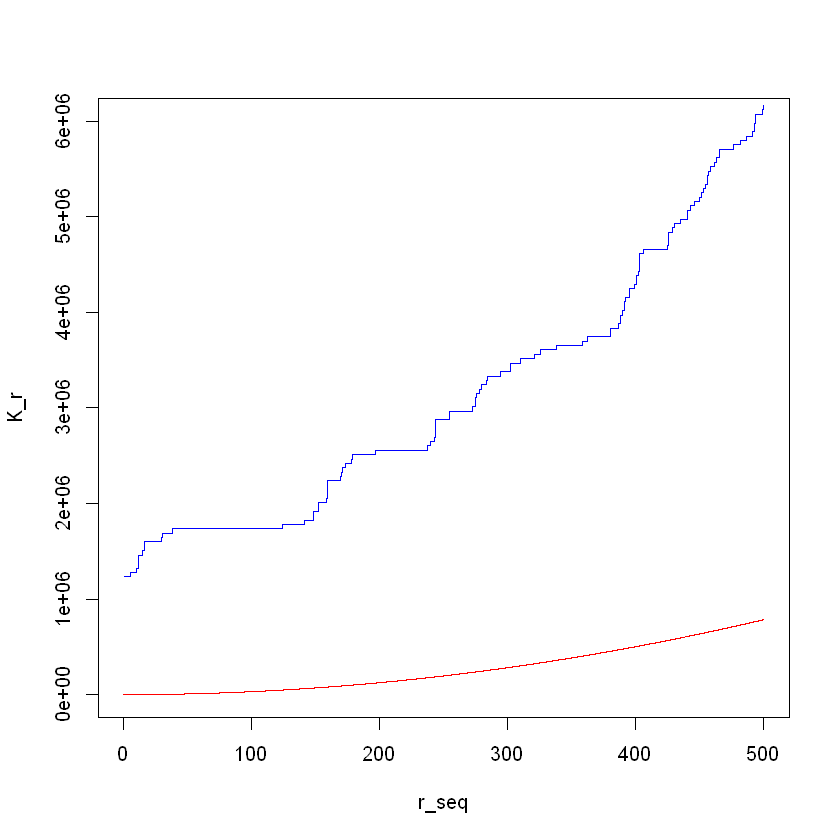

In [5]:
breach_sf <- st_as_sfc(breach)

# Evaluación manual de la función K
coords <- st_coordinates(breach_sf)
N <- nrow(coords)
# Tomando el área que existe entre los puntos
A <- breach_sf %>%
        st_bbox() %>%
        st_as_sfc() %>%
        st_area()
lambda <- N / A
n <- N
d <- as.matrix(dist(coords))

r_seq <- seq(0, 500, 0.01)

K_r <- c()

for (r in r_seq) {
    num <- sum(d < r) - N
    K_r <- append(K_r, num / (lambda * n))
}

plot(r_seq, K_r, type = "n", ylim = c(0, 6000000))
lines(r_seq[-1], K_r[-1], col = "blue")
lines(r_seq, pi * r_seq^2, col = "red")

## Implementación usando *spatstat*

Usando la función de la librería *spatstat*, se obtiene la siguiente gráfica:

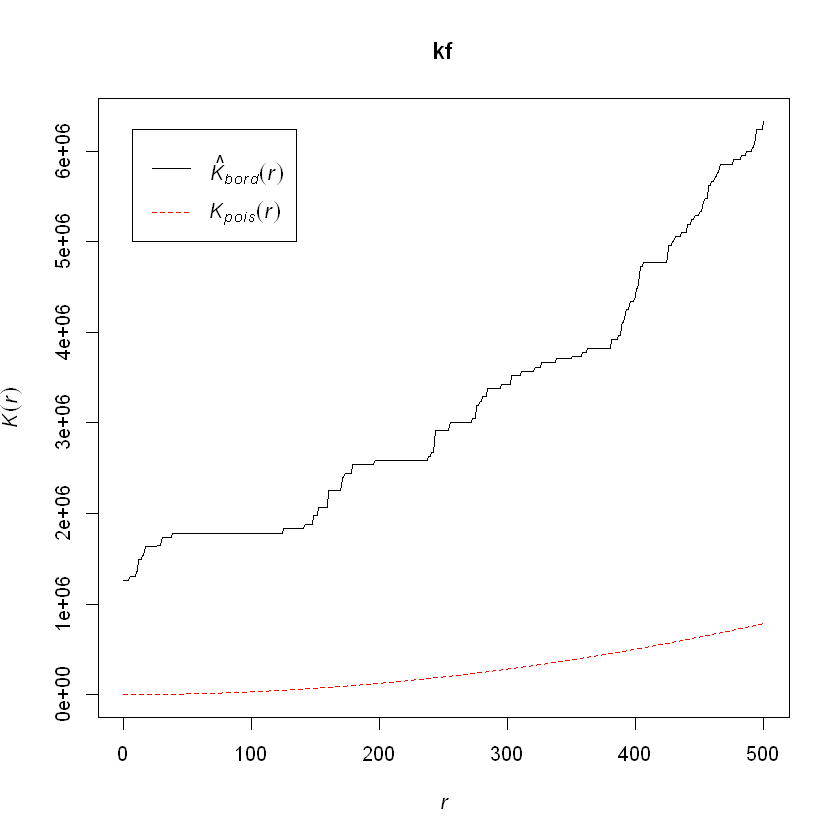

In [6]:
point_pattern <- as.ppp(breach)
kf <- Kest(point_pattern, correction = "border", rmax = 500)
plot(kf)

## Resultados

Ambas gráficas tienen el mismo comportamiento; de hecho, a simple vista son iguales.

Ambas tienen resultados de la función K mayores a los resultados obtenidos usando valores provenientes de una distribución uniforme. Esto se traduce a que la función K revela la existencia de clústeres de eventos dentro del conjunto de datos.

# Evaluación de la función L

Es una transfomación de la función K que permite corregir el incremento de varianza que sufre dicha función conforme el valor de $r$ aumenta, pues mientras el tamaño de los círculos aumenta, también aumenta la varianza entre el número de puntos esperados dentro del círculo.

La transformación que sufre la funcion K usando la función L es la siguiente:

$$L(r) = \sqrt{\frac{K(r)}{\pi}}$$

Como resultado, la gráfica de datos distribuidos uniformemente tendrá como resultado una línea diagonal, mientras que resultados mayores a esta gráfica revelarán la existencia de clústeres dentro del conjunto de datos.

## Implementación manual

La estructura de esta función es similar a la implemetación manual de la función K.

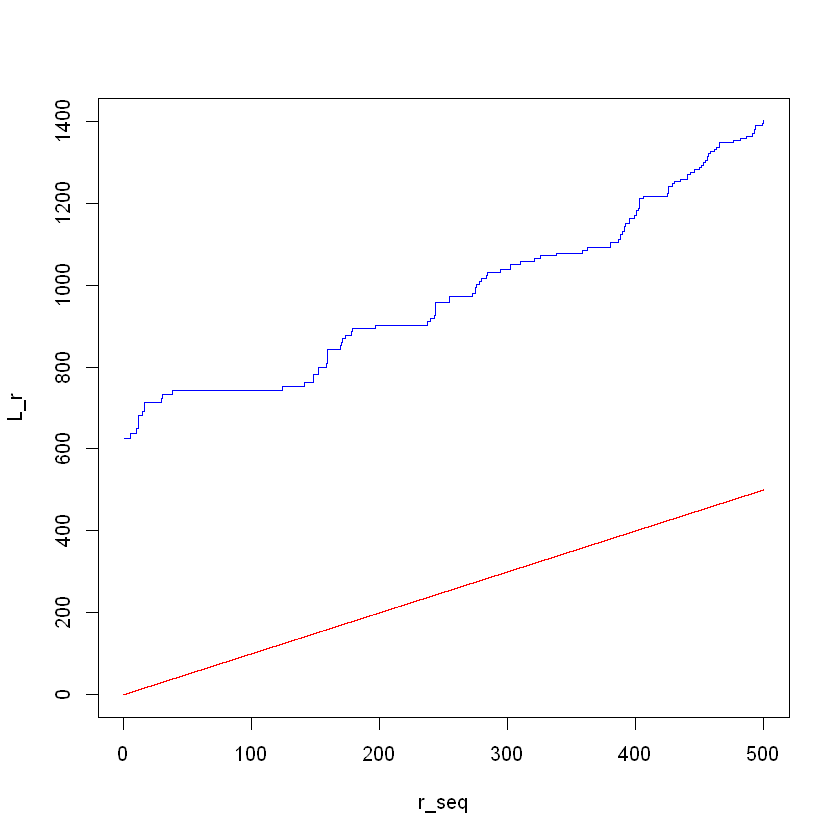

In [7]:
# Evaluación manual de la función L
coords <- st_coordinates(breach_sf)
N <- nrow(coords)
# Tomando el área que existe entre los puntos
A <- breach_sf %>%
        st_bbox() %>%
        st_as_sfc() %>%
        st_area()
lambda <- N / A
n <- N
d <- as.matrix(dist(coords))

r_seq <- seq(0, 500, 0.01)

L_r <- c()

for (r in r_seq) {
    num <- sum(d < r) - N
    K_r <- num / (lambda * n)
    L_r <- append(L_r, sqrt(K_r / pi))
}

plot(r_seq, L_r, type = "n", ylim = c(0, 1400))
lines(r_seq, L_r, col = "blue")
lines(r_seq, r_seq, col = "red")

## Implementación usando *spatstat*

Usando la función de la librería *spatstat*, se obtiene la siguiente gráfica:

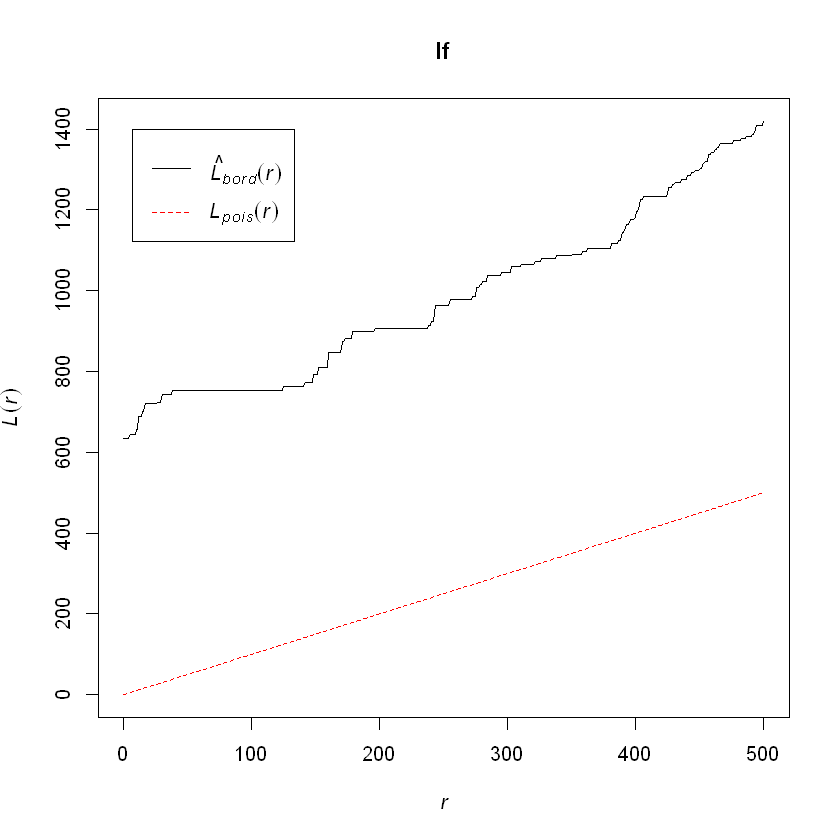

In [8]:
lf <- Lest(point_pattern, correction = "border", rmax = 500)
plot(lf)

## Resultados

Ambos casos presentan un comportamiento muy similar; de hecho, a simple vista son iguales. El comportamiento es muy parecido al obtenido con la función K, con la diferencia de que los valores de Y se encuentran en un rango menor.

Nuevamente, la gráfica que se obtiene como resultado de ambas implementaciones de la función L es mayor que la gráfica obtenida con datos distribuidos uniformemente. Esto confirma finalmente la existencia de clústeres de eventos dentro del conjunto de datos.

# Referencias
GeoDa Software. (2016). *Point Pattern Analysis: K, L and Kd Functions*. Recuperado el 02 de mayo del 2020.
    Disponible en: https://youtu.be/oT_jMTkkld8